<a href="https://colab.research.google.com/github/Pewaukee/cat_dog_classifier/blob/main/Copy_of_fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat and Dog Image Classifier

In this project, we train a model to classify images of animals as either dogs or cats. The website of the documentation used to implement most of this is given [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [24]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [34]:
# this cell is given

# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_do

The directory structure for the project:
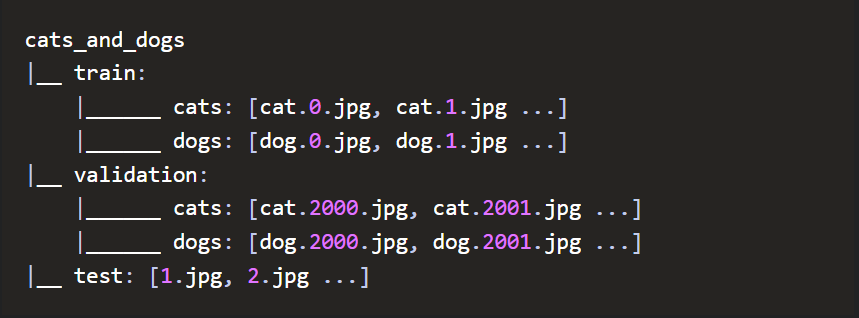

In [35]:
from pickle import TRUE
# 3
# Create image generators for each of the three image data sets 
# (train, validation, test). Use ImageDataGenerator to read / decode 
# the images and convert them into floating point tensors. 
# Use the rescale argument (and no other arguments for now) to rescale
# the tensors from values between 0 and 255 to values between 0 and 1.

# rescale=1./225 multiplies the data by 1/255
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# For the *_data_gen variables, use the flow_from_directory method. 
# Pass in the batch size, directory, target size ((IMG_HEIGHT, IMG_WIDTH)),
# class mode, and anything else required. test_data_gen will be the trickiest
# one. For test_data_gen, make sure to pass in shuffle=False to the 
# flow_from_directory method. This will make sure the final predictions 
# stay is in the order that our test expects. For test_data_gen it will
# also be helpful to observe the directory structure

# class_mode is binary, as the answers are labeled as 1 and 0
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           target_size=((IMG_HEIGHT, IMG_WIDTH)),
                                                           shuffle=True,
                                                           class_mode='binary',
                                                           batch_size=batch_size)
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                         target_size=((IMG_HEIGHT, IMG_WIDTH)),
                                                         shuffle=True,
                                                         class_mode='binary',
                                                         batch_size=batch_size)
test_data_gen = test_image_generator.flow_from_directory(PATH,
                                                         target_size=((IMG_HEIGHT, IMG_WIDTH)),
                                                         shuffle=False,
                                                         class_mode='binary',
                                                         batch_size=batch_size,
                                                         classes=['test'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


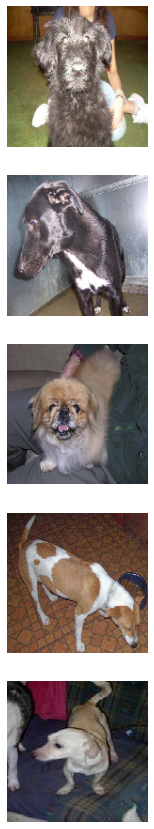

In [36]:
# 4
# The plotImages function will be used a few times to plot images. 
# It takes an array of images and a probabilities list, although the
# probabilities list is optional. This code is given to you. 
# If you created the train_data_gen variable correctly, 
# then running this cell will plot five random training images.

# this cell is given
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


### Overfitting: 
Overfitting occurs when the model cannot generalize and fits too closely to the training dataset instead

In [37]:
# 5
# recreate the train_image_generator with 4-6 random transformations
# in an attempt to avoid overfitting

# random transformations added:
# rotation_range, width_shift_range, height_shift_range, 
# zoom_range, horizonal_flip, and vertical_flip
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=90,
                                           width_shift_range=0.25,
                                           height_shift_range=0.25,
                                           zoom_range=[1-0.1,1+0.1],
                                           horizontal_flip=True,
                                           vertical_flip=True)


Found 2000 images belonging to 2 classes.


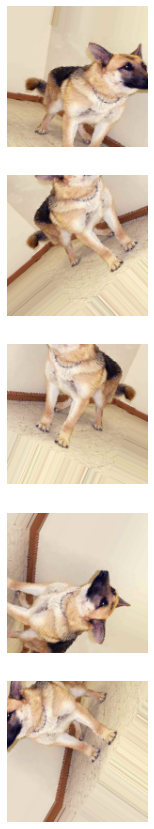

In [38]:
# 6 (given)
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [39]:
train_data_gen.__len__()

16

In [71]:
# 7
# In this cell, create a model for the neural network that outputs
# class probabilities. It should use the Keras Sequential model. 
# It will probably involve a stack of Conv2D and MaxPooling2D layers
# and then a fully connected layer on top that is activated by a 
# ReLU activation function.

# Compile the model passing the arguments to set the optimizer and loss. 
# Also pass in metrics=['accuracy'] to view training and validation accuracy
# for each training epoch.

# layers used in the imports: Dense, Conv2D, Flatten, Dropout, MaxPooling2D
# https://www.simplilearn.com/tutorials/deep-learning-tutorial/guide-to-building-powerful-keras-image-classification-models
model = Sequential([Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(32, kernel_size=(3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(1, activation='sigmoid')]) # pick between 2 different possible outputs




model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 41472)             0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [ ]:
print(type(train_data_gen))

<class 'keras.preprocessing.image.DirectoryIterator'>


In [82]:
# 8
# Use the fit method on your model to train the network.
# Make sure to pass in arguments for x, steps_per_epoch, epochs, 
# validation_data, and validation_steps.

# `y` argument is not supported when using `keras.utils.Sequence` as input
import math

history = model.fit(x=train_data_gen, steps_per_epoch=int(math.ceil((1. * total_train) / batch_size)), 
                    epochs=epochs, batch_size=batch_size,
                    validation_data=val_data_gen,
                    validation_steps=int(math.ceil((1. * total_val / batch_size))))


Epoch 1/15
16/16 [==============================] - 16s 1s/step - loss: 0.6343 - accuracy: 0.6225 - val_loss: 0.6357 - val_accuracy: 0.6200
Epoch 2/15
16/16 [==============================] - 16s 995ms/step - loss: 0.6309 - accuracy: 0.6400 - val_loss: 0.6328 - val_accuracy: 0.6260
Epoch 3/15
16/16 [==============================] - 16s 1s/step - loss: 0.6284 - accuracy: 0.6340 - val_loss: 0.6100 - val_accuracy: 0.6550
Epoch 4/15
16/16 [==============================] - 16s 1s/step - loss: 0.6164 - accuracy: 0.6565 - val_loss: 0.6135 - val_accuracy: 0.6560
Epoch 5/15
16/16 [==============================] - 16s 995ms/step - loss: 0.6256 - accuracy: 0.6515 - val_loss: 0.6195 - val_accuracy: 0.6400
Epoch 6/15
16/16 [==============================] - 16s 993ms/step - loss: 0.6198 - accuracy: 0.6460 - val_loss: 0.6065 - val_accuracy: 0.6820
Epoch 7/15
16/16 [==============================] - 18s 1s/step - loss: 0.6118 - accuracy: 0.6640 - val_loss: 0.6075 - val_accuracy: 0.6700
Epoch 8/15


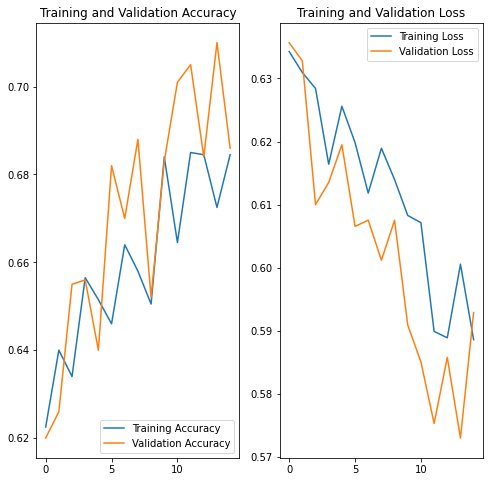

In [83]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 140ms/step


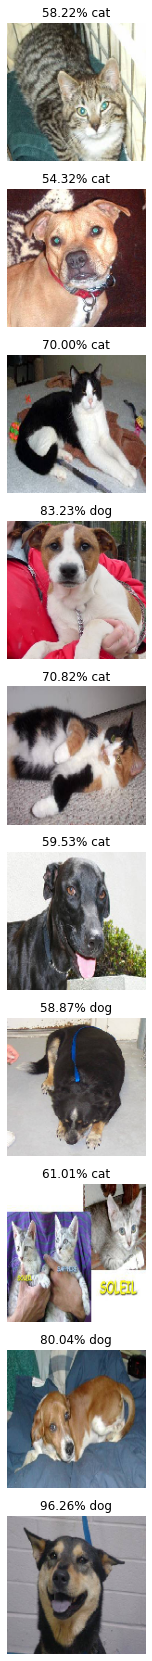

In [84]:
# 10
# In this cell, get the probability that each test image (from test_data_gen) 
# is a dog or a cat. probabilities should be a list of integers.
# Call the plotImages function and pass in the test images and the probabilities
# corresponding to each test image.
# After you run the cell, you should see all 50 test images with a label showing
# the percentage of "sure" that the image is a cat or a dog. The accuracy will 
# correspond to the accuracy shown in the graph above 
# (after running the previous cell). More training images could lead to a higher accuracy.

probabilities = model.predict(test_data_gen) # list of floats (not ints) to determine animals
test_data_images, _ = next(test_data_gen)
plotImages(test_data_images[10:20], probabilities)

In [85]:
# 11, given to test the final result of the model on test data
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!
